In [ ]:
# default_exp engine.microscope

In [ ]:
%load_ext autoreload
%autoreload 2

# Microscope model

> Definition of the classes and functions we use to generate recordings given network outputs or simulations

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.funcs.plotting import *
# import elasticdeform.torch as etorch

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
class Microscope(nn.Module):
    """
    The Mircoscope module takes  5 vectors 'locations', 'x_os', 'y_os', 'z_os',
    'ints_3d' turns them into 3D data through the following steps:
    1) Apply continuous shifts to the PSF according to x_os, y_os, z_os
    2) Clamping the PSF (retaining only positive values)
    3) Normalize the PSF dividing it by it's max value
    6) Place point spread function according to locations  to
    generate 'x_sim'
    7) Multiplies x_sim with scale

    Args:
        psf (torch.nn.Module): Parametric PSF
        noise (torch.nn.Module): Camera noise model
        scale(float): Constant for scaling 
        
    Shape:
        -Input: locations: Tuple(torch.Tensor)
                x_os_val: (N_emitters,)
                y_os_val: (N_emitters,)
                z_os_val: (N_emitters,)
                ints_val: (N_emitters,)
                output_shape: Shape Tuple(BS, C, H, W, D)

        -Output: xsim: (BS, C, H, W, D)
    """


    def __init__(self, psf: torch.nn.Module=None, noise: Union[torch.nn.Module, None]=None, scale: float = 10000., norm='max', sum_fac=1, psf_noise=0):

        super().__init__()
        self.psf = psf
        self.scale = scale
        self.noise = noise
        self.norm = norm
        
        self.theta = self.noise.theta_scale * self.noise.theta_par
        self.sum_fac = sum_fac
        
        self.psf_noise = psf_noise
        
    def add_psf_noise(self, psf_stack):

        '''Gaussian noise'''
        noise = torch.distributions.Normal(loc=0, scale=self.psf_noise).sample(psf_stack.shape).to(psf_stack.device)
        noise *= torch.sqrt(psf_stack)
#         noise *= torch.rand(len(psf_stack), device='cuda')[:,None,None,None,None]

        return psf_stack + noise
    
        '''Individual elastic deformation for each PSF (to slow)'''
#         psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), order=3)[None] 
#                                   for psf in psf_stack[:,0]])
        '''Single deformation for all PSF in batch (kinda stupid)'''
#         psf_deformed = etorch.deform_grid(psf_stack[:,0], torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), axis=(1,2,3),order=3)
#         return psf_deformed[:,None]
        
    def forward(self, locations, x_os_val, y_os_val, z_os_val, i_val, output_shape, eval_=None, add_noise=False):
        
        if len(locations[0]):
            
            if 'max' in self.norm:
                psf_norm = self.psf.psf_volume.max() 
            elif 'sum' in self.norm:
                psf_norm = torch.clamp_min(self.psf.psf_volume, 0).sum()/self.sum_fac
            else:
                psf_norm = 1
            # Apply continuous shift
            psf = self.psf(x_os_val, y_os_val, z_os_val)
            torch.clamp_min_(psf,0)
            psf = psf/psf_norm
            
            if self.psf_noise and add_noise: 
                psf = self.add_psf_noise(psf)
                
            # applying intenseties
            tot_intensity = torch.clamp_min(i_val, 0)
            psf = psf * tot_intensity[:,None,None,None,None]
            # place psf according to locations
            xsim = place_psf(locations, psf, output_shape)
            # scale (not learnable)
            xsim = self.scale * xsim
            if eval_:
                return xsim, psf
            return xsim
        
        else:
            
            return torch.zeros(output_shape).cuda()

In [ ]:
#export
def place_psf(locations, psf_volume, output_shape):
    """
    Places point spread functions (psf_volume) in to corresponding locations.

    Args:
        locations: tuple with the 5D voxel coordinates
        psf_volume: torch.Tensor
        output_shape: Shape Tuple(BS, C, H, W, D) 

    Returns:
        placed_psf: torch.Tensor with shape (BS, C, H, W, D)
    """

    batch, ch, z, y, x = locations
    placed_psf = _place_psf(psf_volume, batch, ch, z, y, x, torch.tensor(output_shape))
    assert placed_psf.shape == output_shape
    return placed_psf

In [ ]:
#export
@script
def _place_psf(psf_vols, b, ch, z, y, x, output_shape):
    '''jit function for placing PSFs
    1) This function will add padding to coordinates (z, y, x) (we need padding in order to place psf on the edges)
    afterwards we will just crop out to original shape
    2) Create empty tensor with paddings loc3d_like
    3) place each individual PSFs in to the corresponding cordinates in loc3d_like
    4) unpad to original output shape

    Args:
        psf_vols:   torch.Tensor
        b:        torch.Tensor
        c:        torch.Tensor
        h:        torch.Tensor
        w:        torch.Tensor
        d:        torch.Tensor
        szs:      torch.Tensor
        
    Shape:
        psf_vols: (Num_E, C, PSF_SZ_X, PSF_SZ_Y, PSF_SZ_Z)
        b:  (Num_E,)
        c:  (Num_E,)
        h:  (Num_E,)
        w:  (Num_E,)
        d:  (Num_E,)
        output_shape:  (BS, Frames, H, W, D)
        
    -Output: placed_psf: (BS, Frames, H, W, D)
        
    '''
    
    psf_b, psf_c, psf_h, psf_w, psf_d = psf_vols.shape
    pad_zyx = [psf_h//2, psf_w//2, psf_d//2]
    #add padding to z, y, x 
    
    z = z + pad_zyx[0]
    y = y + pad_zyx[1]
    x = x + pad_zyx[2]

    #create padded tensor (bs, frame, c, h, w) We will need pad_size * 2 since we are padding from both size
    loc3d_like = torch.zeros(output_shape[0], 
                             output_shape[1], 
                             output_shape[2] + 2*(pad_zyx[0]), 
                             output_shape[3] + 2*(pad_zyx[1]), 
                             output_shape[4] + 2*(pad_zyx[2])).to(x.device)
    
    psf_vols = psf_vols.reshape(-1, psf_h, psf_w, psf_d)

    for idx in range(x.shape[0]):
        loc3d_like[b[idx], ch[idx],
        z[idx]-pad_zyx[0] : z[idx]+pad_zyx[0] + 1,
        y[idx]-pad_zyx[1] : y[idx]+pad_zyx[1] + 1,
        x[idx]-pad_zyx[2] : x[idx]+pad_zyx[2] + 1] += psf_vols[idx]

    b_sz, ch_sz, h_sz, w_sz, d_sz = loc3d_like.shape

    # unpad to original size
    placed_psf = loc3d_like[:, :, pad_zyx[0]: h_sz - pad_zyx[0],
                                  pad_zyx[1]: w_sz - pad_zyx[1],
                                  pad_zyx[2]: d_sz - pad_zyx[2]]
    return placed_psf

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.file_io import get_gaussian_psf
from decode_fish.funcs.output_trafo import sample_to_df

psf = get_gaussian_psf([13,21,21],[1,1,1]).cuda()

noise = sCMOS()

# micro = Microscope(psf=psf, noise=noise, scale=100, norm='sum', sum_fac=psf.psf_volume.sum().item()).cuda()
micro = Microscope(psf=psf, noise=noise, scale=100, norm='max', sum_fac=1, psf_noise=0.5, double_random=True).cuda()

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([2,1,48,48,48]).cuda()*.0001)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()
df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, px_size_zyx=[1,1,1])

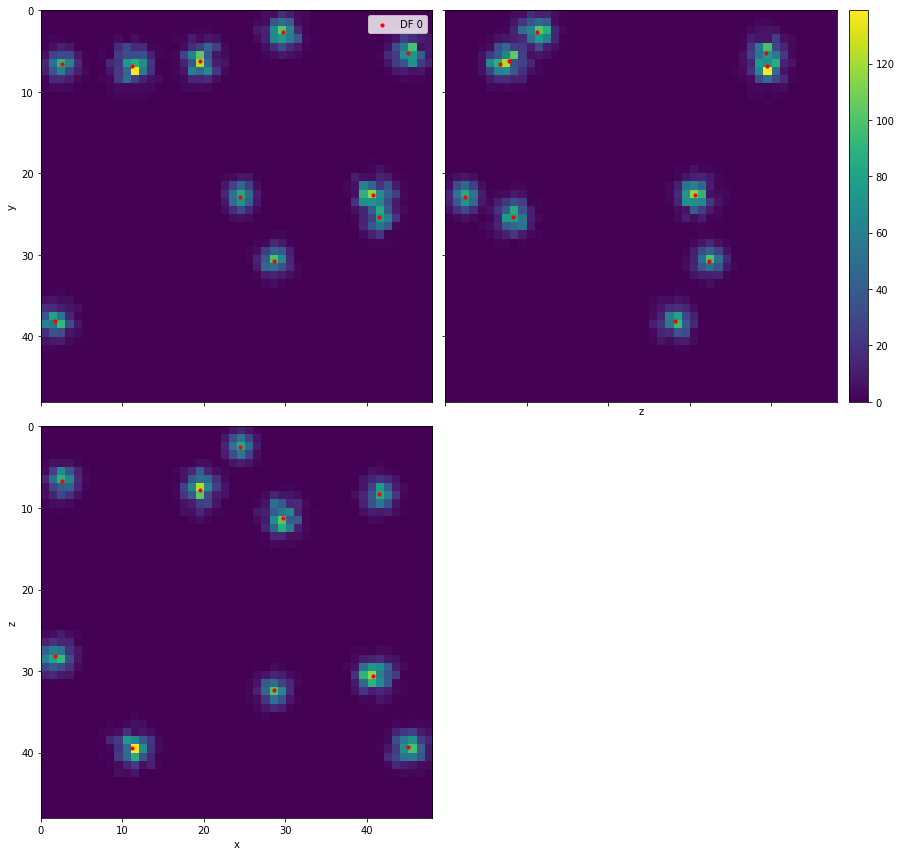

In [ ]:
xsim, psf = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, eval_=True, add_noise=True)
fig, ax = plot_3d_projections(xsim[0,0])
scat_3d_projections(ax, df[df['frame_idx'] == 0])
# xsim.sum()

In [ ]:
from decode_fish.funcs.file_io import load_tiff_image
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/PSF_subsampled.tif')[0]
gt_psf /= gt_psf.max()

In [ ]:
# gt_psf = gt_psf.cuda()
gt_psf_mul = torch.cat(100*[gt_psf[None]])
psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=0.25).sample([3,3,3,3]).to(gt_psf.device), order=3)[None] for psf in gt_psf_mul])

In [ ]:
# gt_psf = gt_psf.cuda()
gt_psf_mul = torch.cat(100*[gt_psf[None]])
deforms = torch.cuda.FloatTensor(100,3,3,3,3).normal_() * 0.25 # torch.distributions.Normal(loc=0, scale=0.25).sample([100,3,3,3,3])
psf_deformed = torch.cat([etorch.deform_grid(psf, deform, order=3)[None] for psf, deform in zip(gt_psf_mul, deforms)])

In [ ]:
psf_deformed = etorch.deform_grid(gt_psf_mul, deforms[0],axis=(1,2,3), order=3)

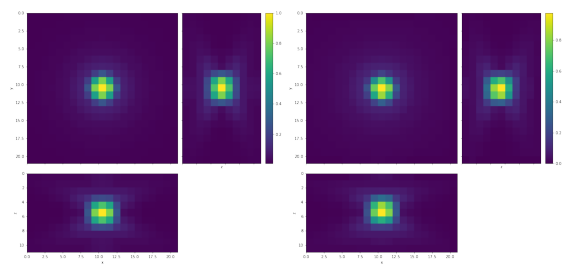

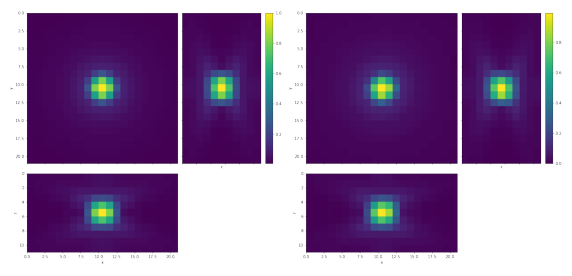

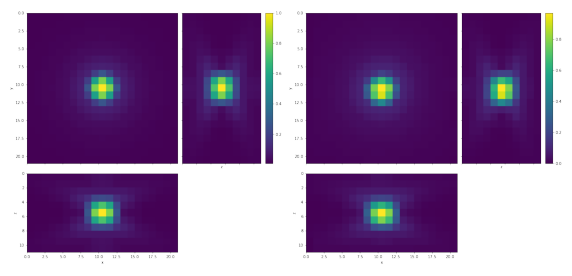

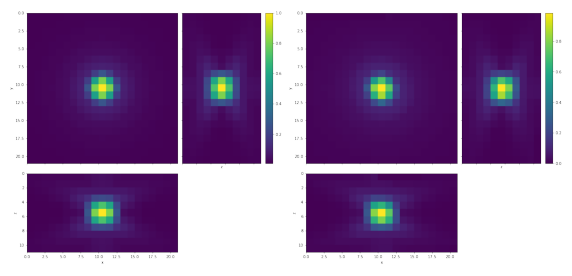

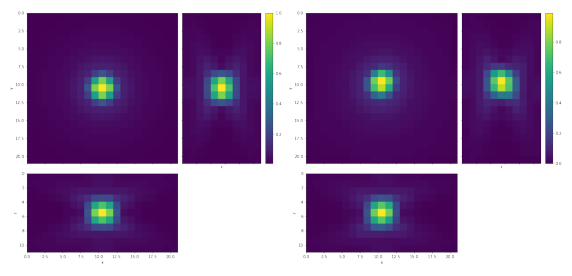

In [ ]:
import elasticdeform.torch as etorch

gt_psf_mul = torch.cat(5*[gt_psf[None]])

psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=0.25).sample([3,3,3,3]).to(gt_psf.device), order=3)[None] for psf in gt_psf_mul])

for i in range(5):
    fig1,_ = plot_3d_projections(gt_psf, display=False)
    fig2,_ = plot_3d_projections(psf_deformed[i], display=False)

    combine_figures([fig1,fig2],[])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
